In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import netCDF4
import math
from scipy.interpolate import griddata
import scipy.stats as st
import cartopy.feature as cfeature 
from cartopy import crs as ccrs;
from shapely.ops import unary_union, cascaded_union
from geopandas.tools import sjoin
from shapely.geometry import Point, shape, Polygon
from cartopy import crs as ccrs;
import geopandas as gpd
from scipy import ndimage, misc
import seaborn as sns
from scipy import ndimage, misc
import matplotlib.path as mpath;
from cartopy.io.shapereader import Reader
import string
import geopandas as gpd
import matplotlib.cm as cm

C:\Users\x12la\AppData\Local\Temp\ipykernel_9060\2759242946.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin


<h1> Load data

In [2]:
## Upload vehicle emission datasets
# FIVE Measures ..
# NOx = NO + NO2  (Harkins, C., McDonald, B. C., Henze, D. K., & Wiedinmyer, C. (2021). A fuel-based method for updating mobile source emissions during the COVID-19 pandemic. Environmental Research Letters. https://doi.org/10.1088/1748-9326/ac0660)
# from McDonald, B. C., Goldstein, A. H., & Harley, R. A. (2015). Long-Term Trends in California Mobile Source Emissions and Ambient Concentrations of Black Carbon and Organic Aerosol. Environmental Science & Technology, 49(8), 5178–5188. https://doi.org/10.1021/es505912b
five= gpd.read_file('Five_4km_cons_censustracts_annual_CMAP.shp') #units ton/km$^2$/hour
five_new= five.to_crs('EPSG:4326')

#LADCO setup described here:  https://doi.org/10.1029/2022JD037942
ladco =  gpd.read_file('ladco_4km_cons_censustracts_annual_CMAP.shp')
ladco_new= ladco.to_crs('EPSG:4326')
                      
# paper currently being written 
rowan = gpd.read_file('UVM_4km_cons_censustracts_annual_CMAP.shp') #units tons/km2/hour
rowan_new = rowan.to_crs('EPSG:4326')

# NEMO https://www.nature.com/articles/s41597-022-01790-9 
nemo = gpd.read_file('nemo_4km_cons_censustracts_annual_CMAP.shp') #units tons/km2/hour
nemo_new= nemo.to_crs('EPSG:4326')

#cook county il
cmap_cty = gpd.read_file('C:/Users/x12la/Desktop/Scripts/CMAP_cty.shp')
cmap_cty = cmap_cty.to_crs('EPSG:4326')

In [3]:
#primary roads
primary_roads = gpd.read_file('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp')
primary_roads = primary_roads.to_crs('EPSG:4326')

In [4]:
# Load US Census tract files
census_tracts = gpd.read_file('../demographic/cmap_census_tracts2018.shp')
census_tracts = census_tracts.to_crs('EPSG:4326')

In [5]:
# Load in NHGIS of the 2014 ACS 
demo_data = pd.read_csv('../demographic/nhgis0010_ds244_20195_tract copy.csv')

<h1> Clip data for domain

In [6]:
# #Clip geopandas files to chicago 
cmap_roads = gpd.clip(primary_roads, cmap_cty.to_crs('EPSG:4326'))
cmap_five = gpd.clip(five_new, cmap_cty.to_crs('EPSG:4326'))
cmap_ladco = gpd.clip(ladco_new, cmap_cty.to_crs('EPSG:4326'))
cmap_rowan = gpd.clip(rowan_new, cmap_cty.to_crs('EPSG:4326'))
cmap_nemo = gpd.clip(nemo_new, cmap_cty.to_crs('EPSG:4326'))

<h1> Join dataaframes 

In [9]:
# Join with census tract shapefile
demo_joined = census_tracts.merge(demo_data, on='GISJOIN')
cmap_tracts = gpd.clip(census_tracts, cmap_cty.to_crs('EPSG:4326'))
cmap_demo = gpd.clip(demo_joined, cmap_cty.to_crs('EPSG:4326'))

In [10]:
#     Table 2:     Hispanic or Latino Origin by Race
#     Universe:    Total population
#     Source code: B03002
#     NHGIS code:  ALUK
#         ALUKE001:    Total
#         ALUKE002:    Not Hispanic or Latino
#         ALUKE003:    Not Hispanic or Latino: White alone
#         ALUKE004:    Not Hispanic or Latino: Black or African American alone
#         ALUKE005:    Not Hispanic or Latino: American Indian and Alaska Native alone
#         ALUKE006:    Not Hispanic or Latino: Asian alone
#         ALUKE007:    Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone
#         ALUKE008:    Not Hispanic or Latino: Some other race alone
#         ALUKE009:    Not Hispanic or Latino: Two or more races
#         ALUKE010:    Not Hispanic or Latino: Two or more races: Two races including Some other race
#         ALUKE011:    Not Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races
#         ALUKE012:    Hispanic or Latino
#         ALUKE013:    Hispanic or Latino: White alone
#         ALUKE014:    Hispanic or Latino: Black or African American alone
#         ALUKE015:    Hispanic or Latino: American Indian and Alaska Native alone
#         ALUKE016:    Hispanic or Latino: Asian alone
#         ALUKE017:    Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone
#         ALUKE018:    Hispanic or Latino: Some other race alone
#         ALUKE019:    Hispanic or Latino: Two or more races
#         ALUKE020:    Hispanic or Latino: Two or more races: Two races including Some other race
#         ALUKE021:    Hispanic or Latino: Two or more races: Two races excluding Some other race, and three or more races

# Rewriting race/ethnicty variables to ones that are easier to follow
# Calculate total population, subgroup population, and percentage of population for each census tract
cmap_demo['pop_total']=pop_total = (cmap_demo['ALUKE003']+cmap_demo['ALUKE004']+cmap_demo['ALUKE005']+cmap_demo['ALUKE006']+
        cmap_demo['ALUKE007']+cmap_demo['ALUKE008']+cmap_demo['ALUKE009']+cmap_demo['ALUKE010']+
        cmap_demo['ALUKE011']+cmap_demo['ALUKE012'])
cmap_demo['white']= cmap_demo['ALUKE003']
cmap_demo['black']= cmap_demo['ALUKE004']
cmap_demo['hispanic']=cmap_demo['ALUKE012']
cmap_demo['asian']=cmap_demo['ALUKE006']
cmap_demo['american_indian'] = cmap_demo['ALUKE005']
cmap_demo['native_hawaiian'] = cmap_demo['ALUKE007']
cmap_demo['two_or_more'] = cmap_demo['ALUKE009'] + cmap_demo['ALUKE010'] + cmap_demo['ALUKE011']
cmap_demo['other']=cmap_demo['ALUKE008']

cmap_demo['Prc_White'] = (cmap_demo['ALUKE003']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_Black'] = (cmap_demo['ALUKE004']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_Asian'] = (cmap_demo['ALUKE006']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_Hispanic'] = (cmap_demo['ALUKE012']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_american_indian'] = (cmap_demo['ALUKE005']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_native_hawaiian'] = (cmap_demo['ALUKE007']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_two_or_more'] = (cmap_demo['ALUKE009']/cmap_demo['ALUKE001'])*100
cmap_demo['Prc_Other'] = ((cmap_demo['ALUKE008'])/cmap_demo['ALUKE001'])*100

<h1> Calculate and plot deciles for absolute nox and pm2.5 emissions (tons/year) and CT demographic composition. Y axis refers to highest emission value within the decile

In [12]:
#################################
####### Absolute Emissions
##################################

# Calculate deciles for NOX and PM2.5 separately
# https://pandas.pydata.org/docs/reference/api/pandas.qcut.html 
for df in [cmap_five, cmap_nemo, cmap_ladco, cmap_rowan]:
    df['NOX_decile'] = pd.qcut(df['NOX'], q=10, labels=False) + 1 # Plus 1 indexs deciles 1 to 10 instead of 0 to 9
    df['PM25_decile'] = pd.qcut(df['PM25'], q=10, labels=False) + 1
    
# Join cmap_demo with cmap_five
cmap_five_emissions_joined = cmap_demo.merge(cmap_five, on='GISJOIN', how='inner')
# Join cmap_demo with cmap_ladco
cmap_ladco_emissions_joined = cmap_demo.merge(cmap_ladco, on='GISJOIN', how='inner')
# Join cmap_demo with cmap_nemo
cmap_nemo_emissions_joined= cmap_demo.merge(cmap_nemo, on='GISJOIN', how='inner')
# Join cmap_demo with cmap_rowan
cmap_rowan_emissions_joined= cmap_demo.merge(cmap_rowan, on='GISJOIN', how='inner')

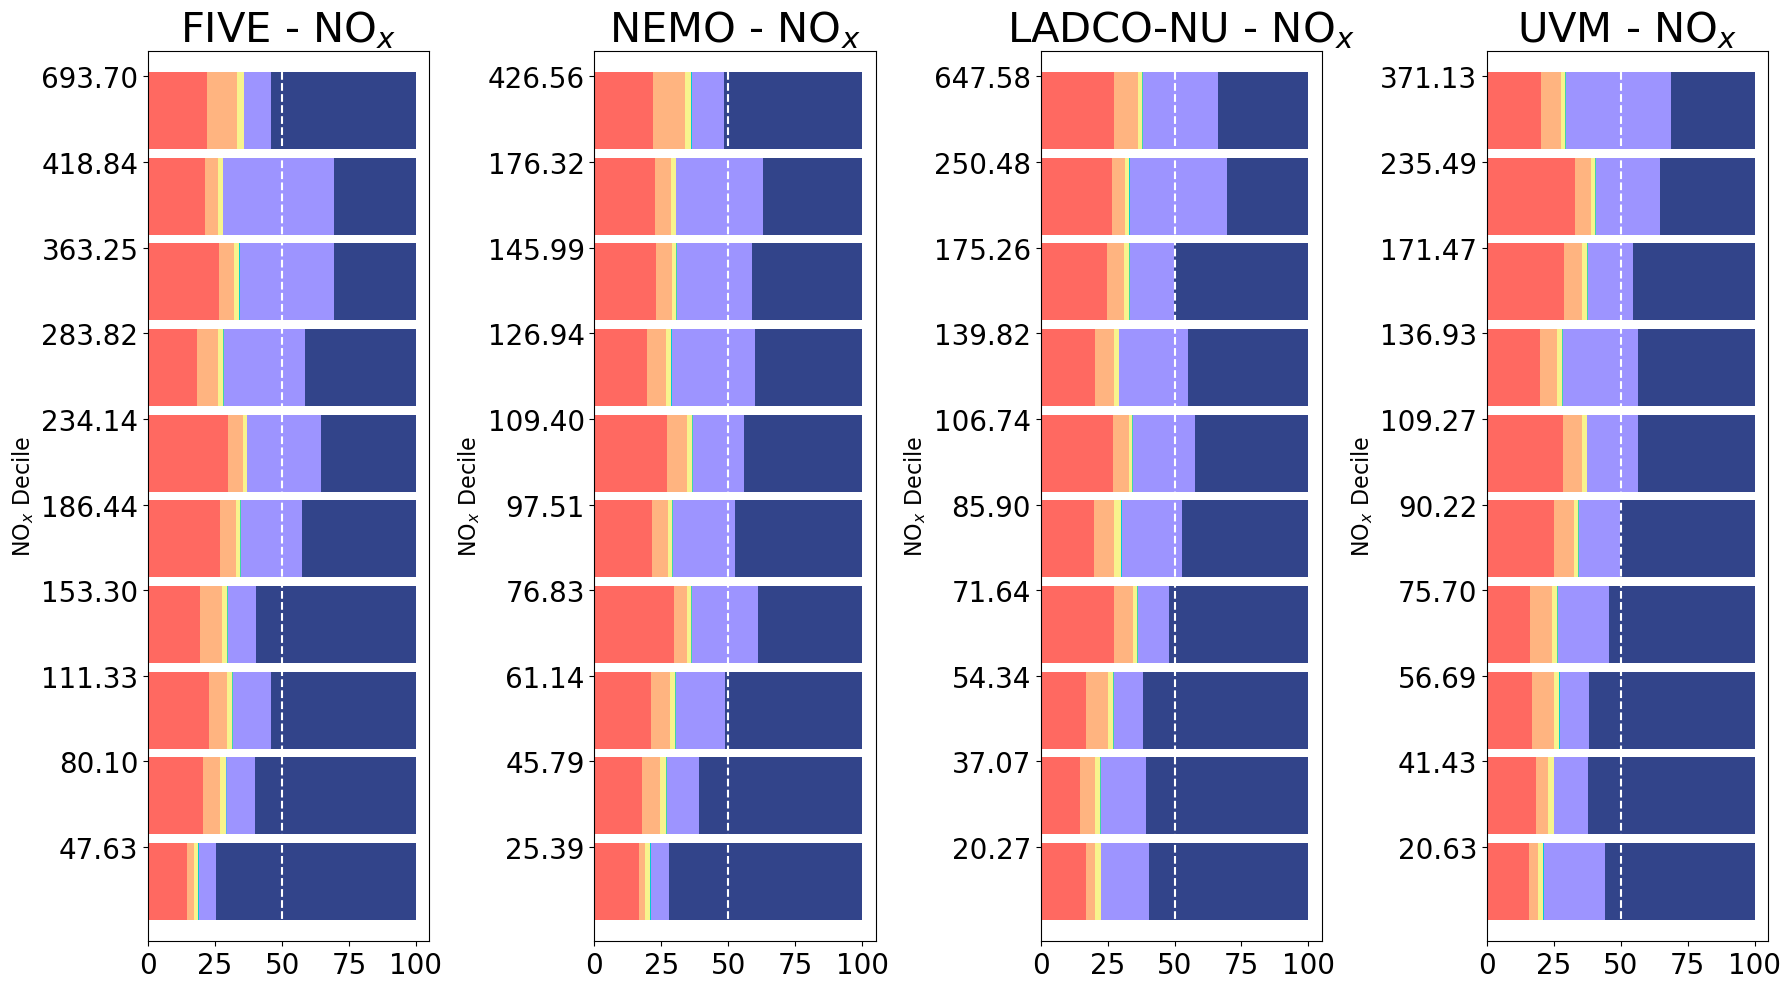

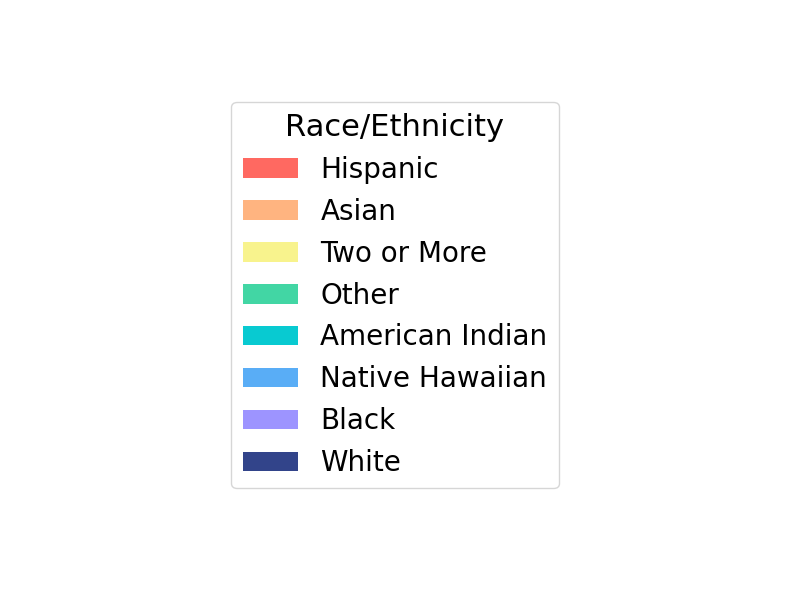

Dataset: FIVE
            Prc_Hispanic  Prc_Asian  Prc_two_or_more  Prc_Other  \
NOX_decile                                                        
1              14.455043   2.507153         1.642099   0.131070   
2              20.370291   6.639041         1.974651   0.177446   
3              22.714077   6.590923         1.964632   0.243924   
4              19.435885   8.287618         1.729015   0.260815   
5              26.916101   5.962654         1.558676   0.239064   
6              29.725499   5.775495         1.321210   0.134884   
7              18.074792   7.862934         2.158337   0.250563   
8              26.639449   5.557543         1.609678   0.210663   
9              21.328360   4.798844         1.725521   0.111085   
10             21.940052  11.201579         2.542055   0.168810   

            Prc_american_indian  Prc_native_hawaiian  Prc_Black  Prc_White  
NOX_decile                                                                  
1                      0.09

In [13]:
#################################
####### Absolute Emissions
##################################
# Function to calculate the average race/ethnicity distribution per decile
def calculate_race_distribution(df):
    race_columns = ['Prc_Hispanic', 'Prc_Asian', 'Prc_two_or_more', 'Prc_Other', 'Prc_american_indian', 'Prc_native_hawaiian', 'Prc_Black', 'Prc_White']
    race_distribution = df.groupby('NOX_decile')[race_columns].mean()
    return race_distribution

# Function to plot stacked bar charts for all 10 deciles for all four datasets
def plot_stacked_bar(df_list, titles):
    colors = ['#ff6961', '#ffb480', '#f8f38d', '#42d6a4', '#08cad1', '#59adf6', '#9d94ff', '#32448A']  # Define colors
    fig, axs = plt.subplots(1, 4, figsize=(18, 10))  # Create one row with four columns for subplots
    # Adjust bar width
    bar_width = 0.9
    
    for i, df in enumerate(df_list):
        race_distribution = calculate_race_distribution(df)
        race_distribution.plot(kind='barh', stacked=True, ax=axs[i], legend=None, color=colors, width=bar_width) # Use specified colors
        axs[i].set_title(titles[i] + ' - NO$_x$', fontsize=30)
        axs[i].set_ylabel('NO$_x$ Decile', fontsize=16)  # Adjust y-axis label

        # Draw white dotted line at 50% mark
        axs[i].axvline(x=50, color='white', linestyle='--')
        
        # Set x ticks
        axs[i].set_xticks([0, 25, 50, 75, 100])
        axs[i].set_xticklabels(['0', '25', '50', '75', '100'], fontsize=20)
       
        # Set y ticks and labels using max_nox_values
        max_nox_values = df.groupby('NOX_decile')['NOX'].max()
        max_nox_values_rounded = max_nox_values.round(2)  # Round to 2 decimal points
        
        # Calculate y-ticks position
        y_ticks_position = range(1, len(max_nox_values_rounded) + 1)
        bar_middle = [tick - bar_width + 0.3 for tick in y_ticks_position]  # Adjust y-ticks position
        axs[i].set_yticks(bar_middle)
        axs[i].set_yticklabels([f'{max_value:.2f}' for max_value in max_nox_values_rounded], fontsize=12)
       
        # Set y tick labels font size
        axs[i].tick_params(axis='y', labelsize=20)

    plt.tight_layout()
    plt.savefig('NOX_4km_EquityPlot.png')
    plt.show()
    
    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(8, 6))
    handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from any subplot
    custom_labels = ['Hispanic', 'Asian', 'Two or More', 'Other', 'American Indian', 'Native Hawaiian', 'Black', 'White']  # Custom legend labels
    fig_legend.legend(handles, custom_labels, loc='center', fontsize=20, title='Race/Ethnicity', title_fontsize=22)  # Create legend in new figure
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('NOX_1km_EquityPlot_Legend.png')
    plt.show()

# Merge emissions with demographic data
cmap_datasets = [cmap_five_emissions_joined, cmap_nemo_emissions_joined, cmap_ladco_emissions_joined, cmap_rowan_emissions_joined]
titles = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

plot_stacked_bar(cmap_datasets, titles)

# Print the composition of each decile for each dataset
for i, df in enumerate(cmap_datasets):
    print(f"Dataset: {titles[i]}")
    race_distribution = calculate_race_distribution(df)
    print(race_distribution)
    print()


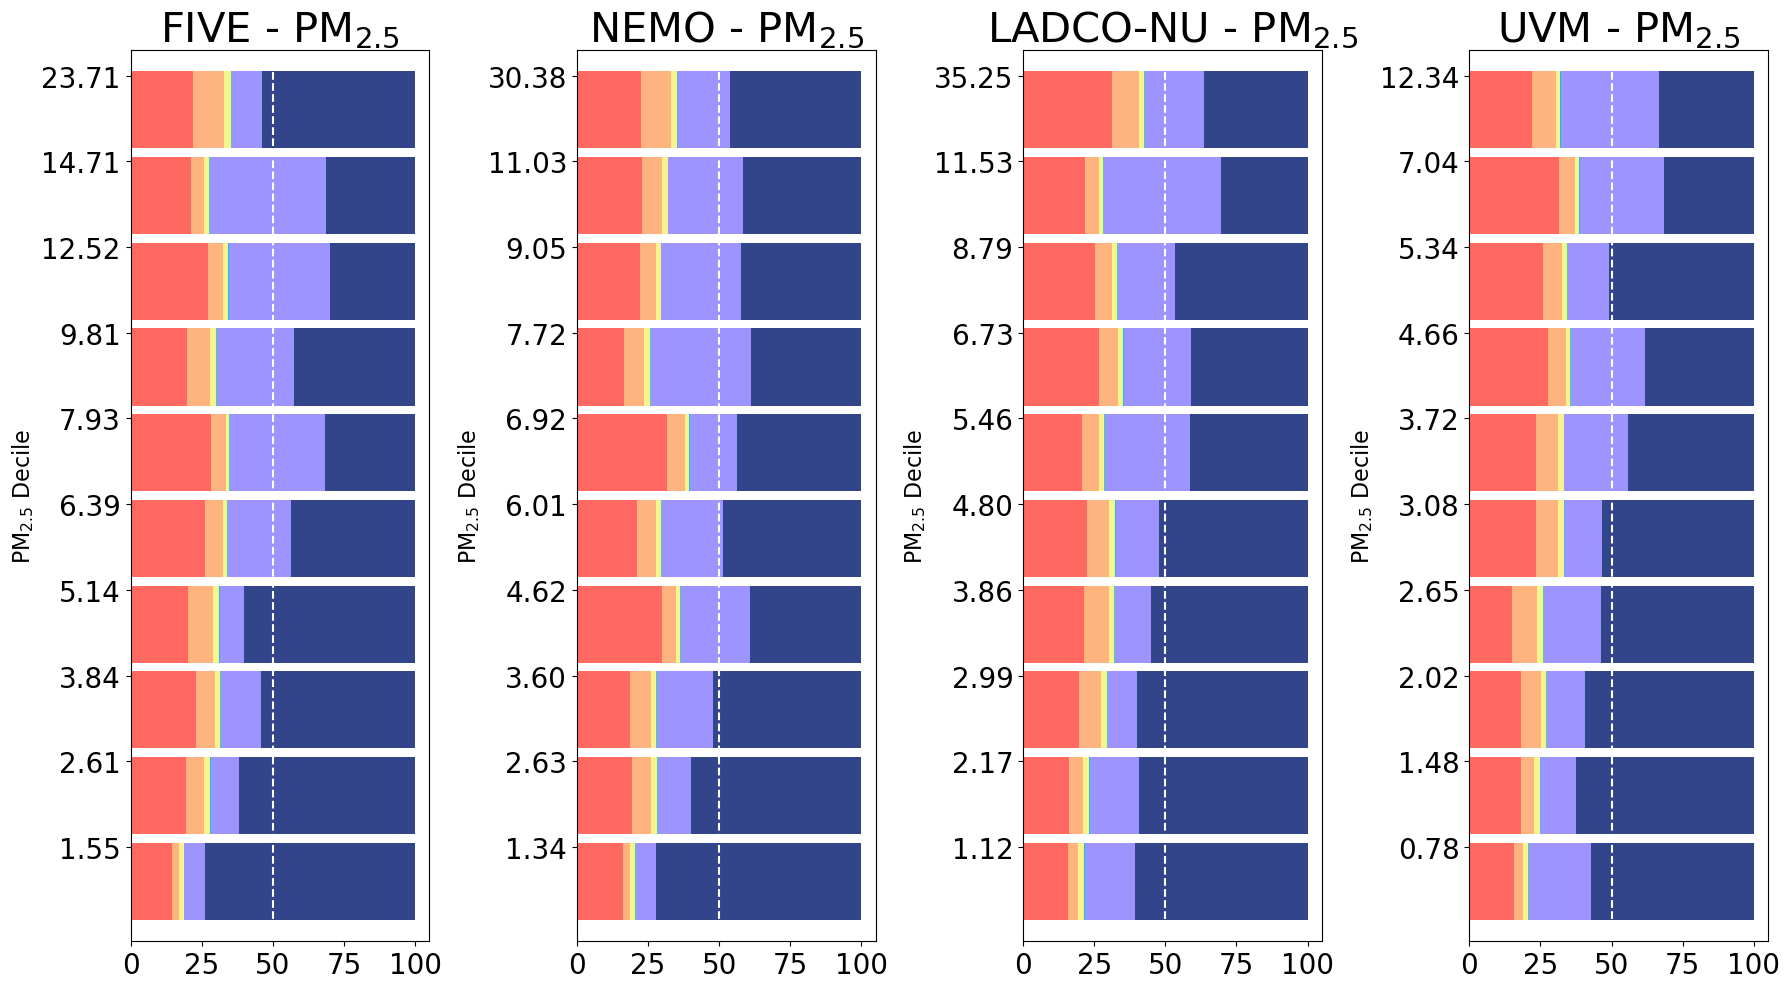

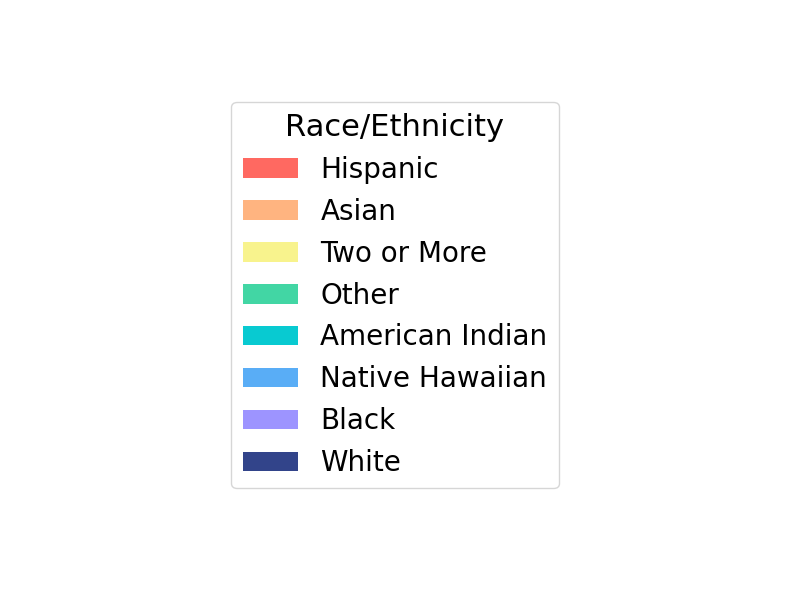

Dataset: FIVE
             Prc_Hispanic  Prc_Asian  Prc_two_or_more  Prc_Other  \
PM25_decile                                                        
1               14.520707   2.462255         1.645730   0.130892   
2               19.415771   6.498314         2.015694   0.151723   
3               22.968850   6.707440         1.884510   0.245518   
4               20.188834   8.964379         1.774518   0.287271   
5               26.298230   6.027275         1.580858   0.235958   
6               28.336430   5.064640         1.287636   0.135176   
7               19.822673   8.025734         2.167839   0.248804   
8               27.105663   5.513168         1.609306   0.179133   
9               21.119878   4.801142         1.749287   0.140142   
10              21.858333  11.050521         2.495929   0.168810   

             Prc_american_indian  Prc_native_hawaiian  Prc_Black  Prc_White  
PM25_decile                                                                  
1            

In [14]:
#################################
####### Absolute Emissions
##################################
# Function to calculate the average race/ethnicity distribution per decile
def calculate_race_distribution(df):
    race_columns = ['Prc_Hispanic', 'Prc_Asian', 'Prc_two_or_more', 'Prc_Other', 'Prc_american_indian', 'Prc_native_hawaiian', 'Prc_Black', 'Prc_White']
    race_distribution = df.groupby('PM25_decile')[race_columns].mean()
    return race_distribution

# Function to plot stacked bar charts for all 10 deciles for all four datasets
def plot_stacked_bar(df_list, titles):
    colors = ['#ff6961', '#ffb480', '#f8f38d', '#42d6a4', '#08cad1', '#59adf6', '#9d94ff', '#32448A']  # Define colors
    fig, axs = plt.subplots(1, 4, figsize=(18, 10))  # Create one row with four columns for subplots
    # Adjust bar width
    bar_width = 0.9
    
    for i, df in enumerate(df_list):
        race_distribution = calculate_race_distribution(df)
        race_distribution.plot(kind='barh', stacked=True, ax=axs[i], legend=None, color=colors, width=bar_width) # Use specified colors
        axs[i].set_title(titles[i] + ' - PM$_{2.5}$', fontsize=30)
        axs[i].set_ylabel('PM$_{2.5}$ Decile', fontsize=16)  # Adjust y-axis label

        # Draw white dotted line at 50% mark
        axs[i].axvline(x=50, color='white', linestyle='--')
        
        # Set x ticks
        axs[i].set_xticks([0, 25, 50, 75, 100])
        axs[i].set_xticklabels(['0', '25', '50', '75', '100'], fontsize=20)
       
        # Set y ticks and labels using max_pm25_values
        max_pm25_values = df.groupby('PM25_decile')['PM25'].max()
        max_pm25_values_rounded = max_pm25_values.round(2)  # Round to 2 decimal points
        
        # Calculate y-ticks position
        y_ticks_position = range(1, len(max_pm25_values_rounded) + 1)
        bar_middle = [tick - bar_width + 0.3 for tick in y_ticks_position]  # Adjust y-ticks position
        axs[i].set_yticks(bar_middle)
        axs[i].set_yticklabels([f'{max_value:.2f}' for max_value in max_pm25_values_rounded], fontsize=12)
       
        # Set y tick labels font size
        axs[i].tick_params(axis='y', labelsize=20)

    plt.tight_layout()
    plt.savefig('PM25_1km_EquityPlot.png')
    plt.show()
    
    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(8, 6))
    handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from any subplot
    custom_labels = ['Hispanic', 'Asian', 'Two or More', 'Other', 'American Indian', 'Native Hawaiian', 'Black', 'White']  # Custom legend labels
    fig_legend.legend(handles, custom_labels, loc='center', fontsize=20, title='Race/Ethnicity', title_fontsize=22)  # Create legend in new figure
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('PM25_4km_EquityPlot_Legend.png')
    plt.show()

# Merge emissions with demographic data
cmap_datasets = [cmap_five_emissions_joined, cmap_nemo_emissions_joined, cmap_ladco_emissions_joined, cmap_rowan_emissions_joined]
titles = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

plot_stacked_bar(cmap_datasets, titles)

# Print the composition of each decile for each dataset
for i, df in enumerate(cmap_datasets):
    print(f"Dataset: {titles[i]}")
    race_distribution = calculate_race_distribution(df)
    print(race_distribution)
    print()


<h1>Calculate and plot deciles for emission flux nox and pm2.5 emissions (tons/km2/year) and CT demographic composition. Y axis refers to highest emission value within the decile

In [15]:
#################################
####### Emission Flux
##################################
# Calculate deciles for NOX and PM2.5 separately
for df in [cmap_five, cmap_nemo, cmap_ladco, cmap_rowan]:
    df['NOX_flux_decile'] = pd.qcut((df['NOX_flux']), q=10, labels=False) + 1
    df['PM25_flux_decile'] = pd.qcut((df['PM25_flux']), q=10, labels=False) + 1
    
# Join cmap_demo with each emissions DataFrame
cmap_five_emissions_joined = cmap_demo.merge(cmap_five, on='GISJOIN', how='inner')
cmap_ladco_emissions_joined = cmap_demo.merge(cmap_ladco, on='GISJOIN', how='inner')
cmap_nemo_emissions_joined = cmap_demo.merge(cmap_nemo, on='GISJOIN', how='inner')
cmap_rowan_emissions_joined = cmap_demo.merge(cmap_rowan, on='GISJOIN', how='inner')

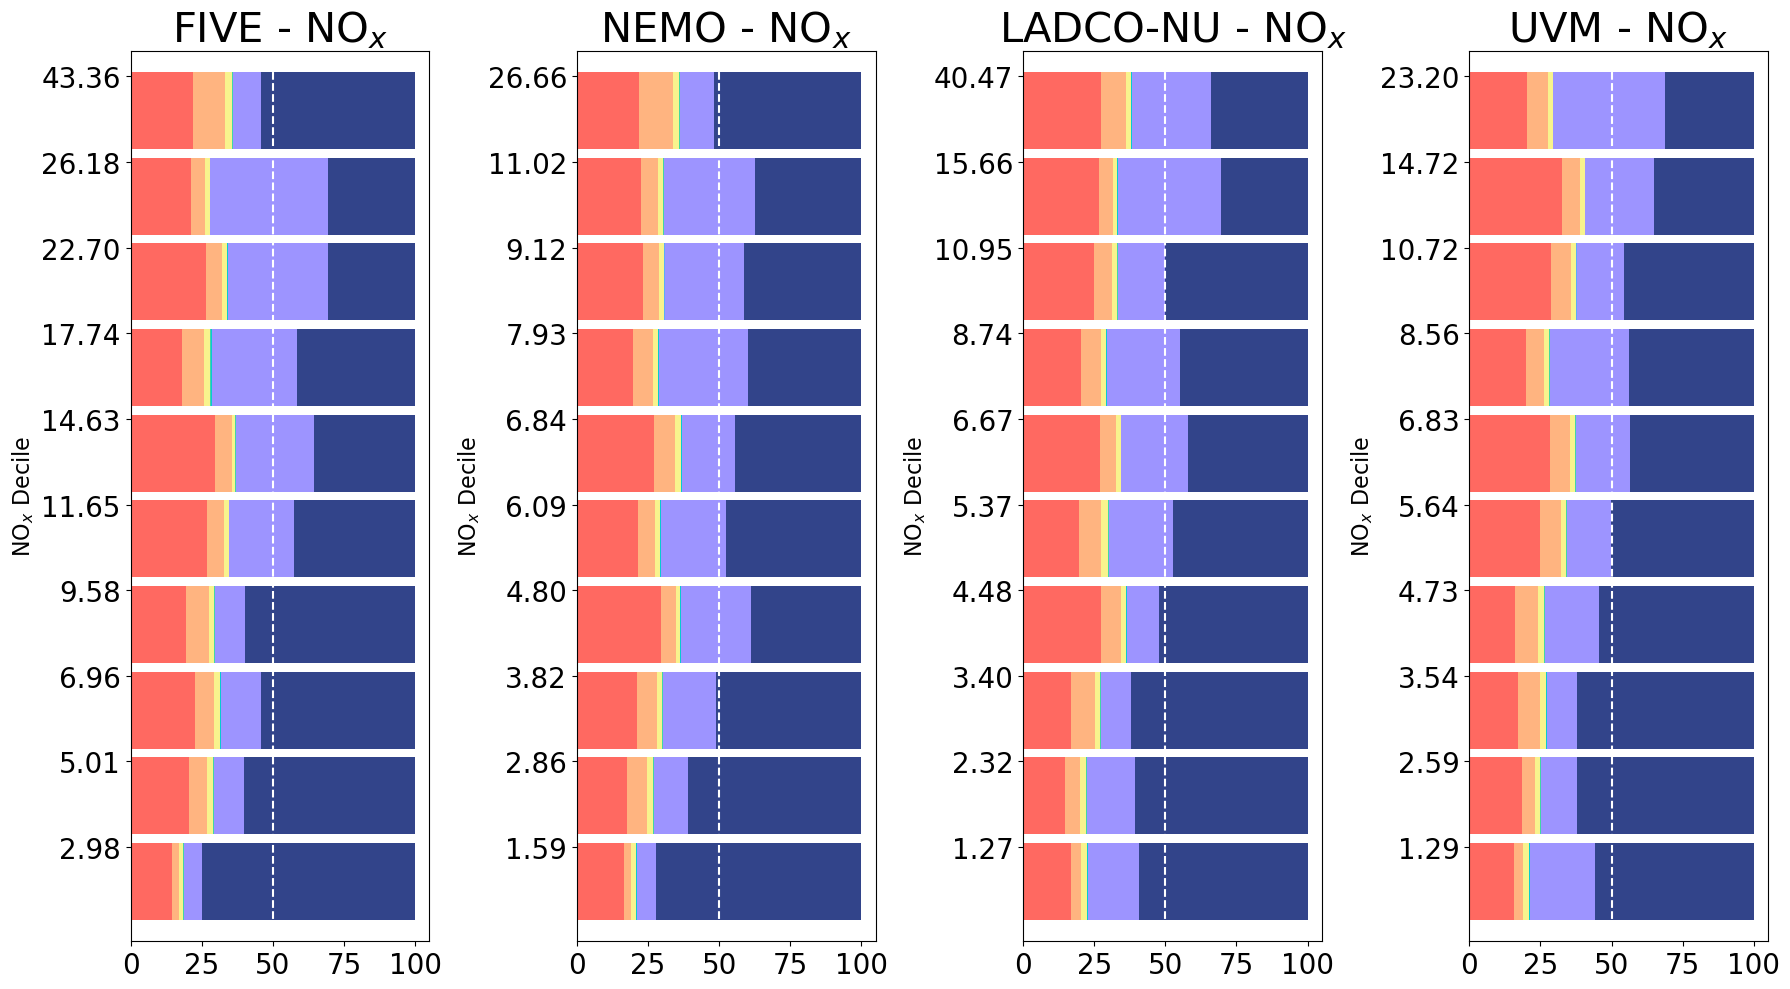

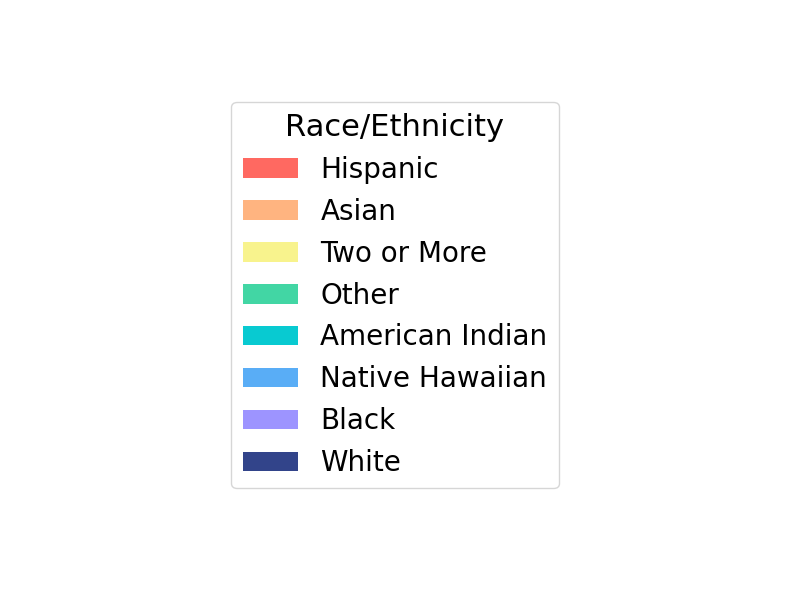

Dataset: FIVE
                 Prc_Hispanic  Prc_Asian  Prc_two_or_more  Prc_Other  \
NOX_flux_decile                                                        
1                   14.455043   2.507153         1.642099   0.131070   
2                   20.370291   6.639041         1.974651   0.177446   
3                   22.714077   6.590923         1.964632   0.243924   
4                   19.435885   8.287618         1.729015   0.260815   
5                   26.916101   5.962654         1.558676   0.239064   
6                   29.725499   5.775495         1.321210   0.134884   
7                   18.074792   7.862934         2.158337   0.250563   
8                   26.639449   5.557543         1.609678   0.210663   
9                   21.328360   4.798844         1.725521   0.111085   
10                  21.940052  11.201579         2.542055   0.168810   

                 Prc_american_indian  Prc_native_hawaiian  Prc_Black  \
NOX_flux_decile                                  

In [16]:
#################################
####### Emission Flux
##################################
# Function to calculate the average race/ethnicity distribution per decile
def calculate_race_distribution(df):
    race_columns = ['Prc_Hispanic', 'Prc_Asian', 'Prc_two_or_more', 'Prc_Other', 
                    'Prc_american_indian', 'Prc_native_hawaiian', 'Prc_Black', 'Prc_White']
    race_distribution = df.groupby('NOX_flux_decile')[race_columns].mean()
    return race_distribution

# Function to plot stacked bar charts for all 10 deciles for all four datasets
def plot_stacked_bar(df_list, titles):
    colors = ['#ff6961', '#ffb480', '#f8f38d', '#42d6a4', '#08cad1', '#59adf6', '#9d94ff', '#32448A']
    fig, axs = plt.subplots(1, 4, figsize=(18, 10))
    bar_width = 0.9
    
    for i, df in enumerate(df_list):
        race_distribution = calculate_race_distribution(df)
        race_distribution.plot(kind='barh', stacked=True, ax=axs[i], legend=None, color=colors, width=bar_width)
        axs[i].set_title(titles[i] + ' - NO$_x$', fontsize=30)
        axs[i].set_ylabel('NO$_x$ Decile', fontsize=16)

        axs[i].axvline(x=50, color='white', linestyle='--')
        axs[i].set_xticks([0, 25, 50, 75, 100])
        axs[i].set_xticklabels(['0', '25', '50', '75', '100'], fontsize=20)
       
       # Modify the max_nox_values calculation to plot the MAX NOx flux where NOX/1.33**2
        max_nox_values = df.groupby('NOX_flux_decile')['NOX_flux'].max()
        max_nox_values_rounded = max_nox_values.round(2)
        y_ticks_position = range(1, len(max_nox_values_rounded) + 1)
        bar_middle = [tick - bar_width + 0.3 for tick in y_ticks_position]
        axs[i].set_yticks(bar_middle)
        axs[i].set_yticklabels([f'{max_value:.2f}' for max_value in max_nox_values_rounded], fontsize=12)
        axs[i].tick_params(axis='y', labelsize=20)

    plt.tight_layout()
    plt.savefig('NOX_1km_EquityPlot.png')
    plt.show()
    
    fig_legend = plt.figure(figsize=(8, 6))
    handles, labels = axs[0].get_legend_handles_labels()
    custom_labels = ['Hispanic', 'Asian', 'Two or More', 'Other', 'American Indian', 
                     'Native Hawaiian', 'Black', 'White']
    fig_legend.legend(handles, custom_labels, loc='center', fontsize=20, 
                      title='Race/Ethnicity', title_fontsize=22)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('NOX_flux_1_33km_EquityPlot_Legend.png')
    plt.show()

# Merge emissions with demographic data
cmap_datasets = [cmap_five_emissions_joined, cmap_nemo_emissions_joined, 
                 cmap_ladco_emissions_joined, cmap_rowan_emissions_joined]
titles = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

plot_stacked_bar(cmap_datasets, titles)

# Print the composition of each decile for each dataset
for i, df in enumerate(cmap_datasets):
    print(f"Dataset: {titles[i]}")
    race_distribution = calculate_race_distribution(df)
    print(race_distribution)
    print()

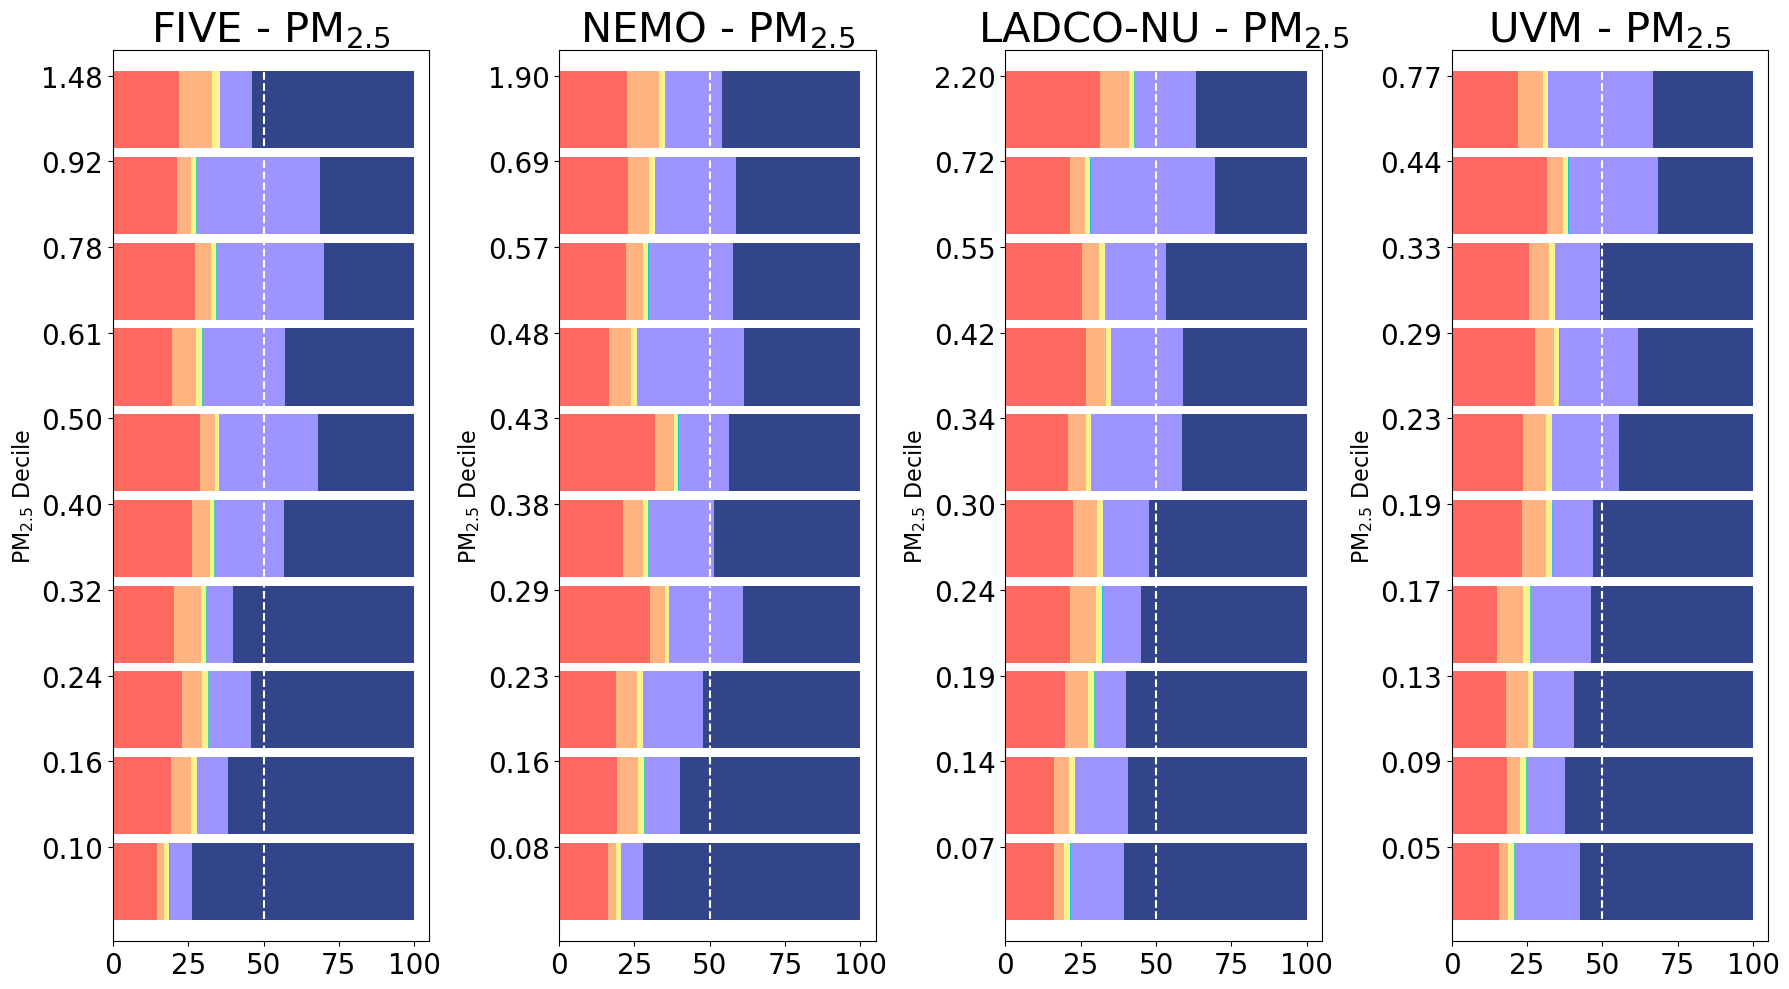

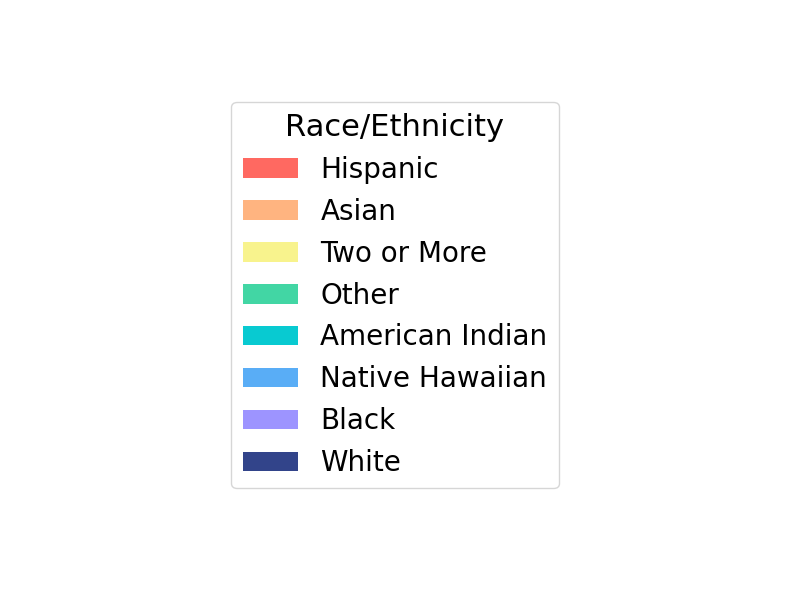

Dataset: FIVE
                  Prc_Hispanic  Prc_Asian  Prc_two_or_more  Prc_Other  \
PM25_flux_decile                                                        
1                    14.520707   2.462255         1.645730   0.130892   
2                    19.415771   6.498314         2.015694   0.151723   
3                    22.968850   6.707440         1.884510   0.245518   
4                    20.188834   8.964379         1.774518   0.287271   
5                    26.110558   5.975539         1.567157   0.233742   
6                    28.913647   5.085306         1.292991   0.135869   
7                    19.446964   8.064884         2.178414   0.250018   
8                    27.105663   5.513168         1.609306   0.179133   
9                    21.119878   4.801142         1.749287   0.140142   
10                   21.858333  11.050521         2.495929   0.168810   

                  Prc_american_indian  Prc_native_hawaiian  Prc_Black  \
PM25_flux_decile                    

In [21]:
#################################
####### Emission Flux
##################################

# Function to calculate the average race/ethnicity distribution per decile for PM2.5
def calculate_race_distribution(df):
    race_columns = ['Prc_Hispanic', 'Prc_Asian', 'Prc_two_or_more', 'Prc_Other', 
                    'Prc_american_indian', 'Prc_native_hawaiian', 'Prc_Black', 'Prc_White']
    race_distribution = df.groupby('PM25_flux_decile')[race_columns].mean()
    return race_distribution

# Function to plot stacked bar charts for all 10 deciles for PM2.5 flux across all four datasets
def plot_stacked_bar(df_list, titles):
    colors = ['#ff6961', '#ffb480', '#f8f38d', '#42d6a4', '#08cad1', '#59adf6', '#9d94ff', '#32448A']
    fig, axs = plt.subplots(1, 4, figsize=(18, 10))
    bar_width = 0.9
    
    for i, df in enumerate(df_list):
        race_distribution = calculate_race_distribution(df)
        race_distribution.plot(kind='barh', stacked=True, ax=axs[i], legend=None, color=colors, width=bar_width)
        axs[i].set_title(titles[i] + ' - PM$_{2.5}$', fontsize=30)
        axs[i].set_ylabel('PM$_{2.5}$ Decile', fontsize=16)

        axs[i].axvline(x=50, color='white', linestyle='--')
        axs[i].set_xticks([0, 25, 50, 75, 100])
        axs[i].set_xticklabels(['0', '25', '50', '75', '100'], fontsize=20)
       
        # Set y ticks and labels using max_pm25_values
        max_pm25_values = df.groupby('PM25_flux_decile')['PM25_flux'].max()
        max_pm25_values_rounded = max_pm25_values.round(2)
        y_ticks_position = range(1, len(max_pm25_values_rounded) + 1)
        bar_middle = [tick - bar_width + 0.3 for tick in y_ticks_position]
        axs[i].set_yticks(bar_middle)
        axs[i].set_yticklabels([f'{max_value:.2f}' for max_value in max_pm25_values_rounded], fontsize=12)
        axs[i].tick_params(axis='y', labelsize=20)

    plt.tight_layout()
    plt.savefig('PM25_flux_1km_EquityPlot.png')
    plt.show()
    
    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(8, 6))
    handles, labels = axs[0].get_legend_handles_labels()
    custom_labels = ['Hispanic', 'Asian', 'Two or More', 'Other', 'American Indian', 
                     'Native Hawaiian', 'Black', 'White']
    fig_legend.legend(handles, custom_labels, loc='center', fontsize=20, 
                      title='Race/Ethnicity', title_fontsize=22)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('PM25_flux_1_33km_EquityPlot_Legend.png')
    plt.show()

# Merge emissions with demographic data
cmap_datasets = [cmap_five_emissions_joined, cmap_nemo_emissions_joined, 
                 cmap_ladco_emissions_joined, cmap_rowan_emissions_joined]
titles = ['FIVE', 'NEMO', 'LADCO-NU', 'UVM']

plot_stacked_bar(cmap_datasets, titles)

# Print the composition of each decile for each dataset
for i, df in enumerate(cmap_datasets):
    print(f"Dataset: {titles[i]}")
    race_distribution = calculate_race_distribution(df)
    print(race_distribution)
    print()


<h1> plot 10th decile census tracts for absolute emissions and emission flux

C:\Users\x12la\AppData\Local\Temp\ipykernel_9060\2700239318.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


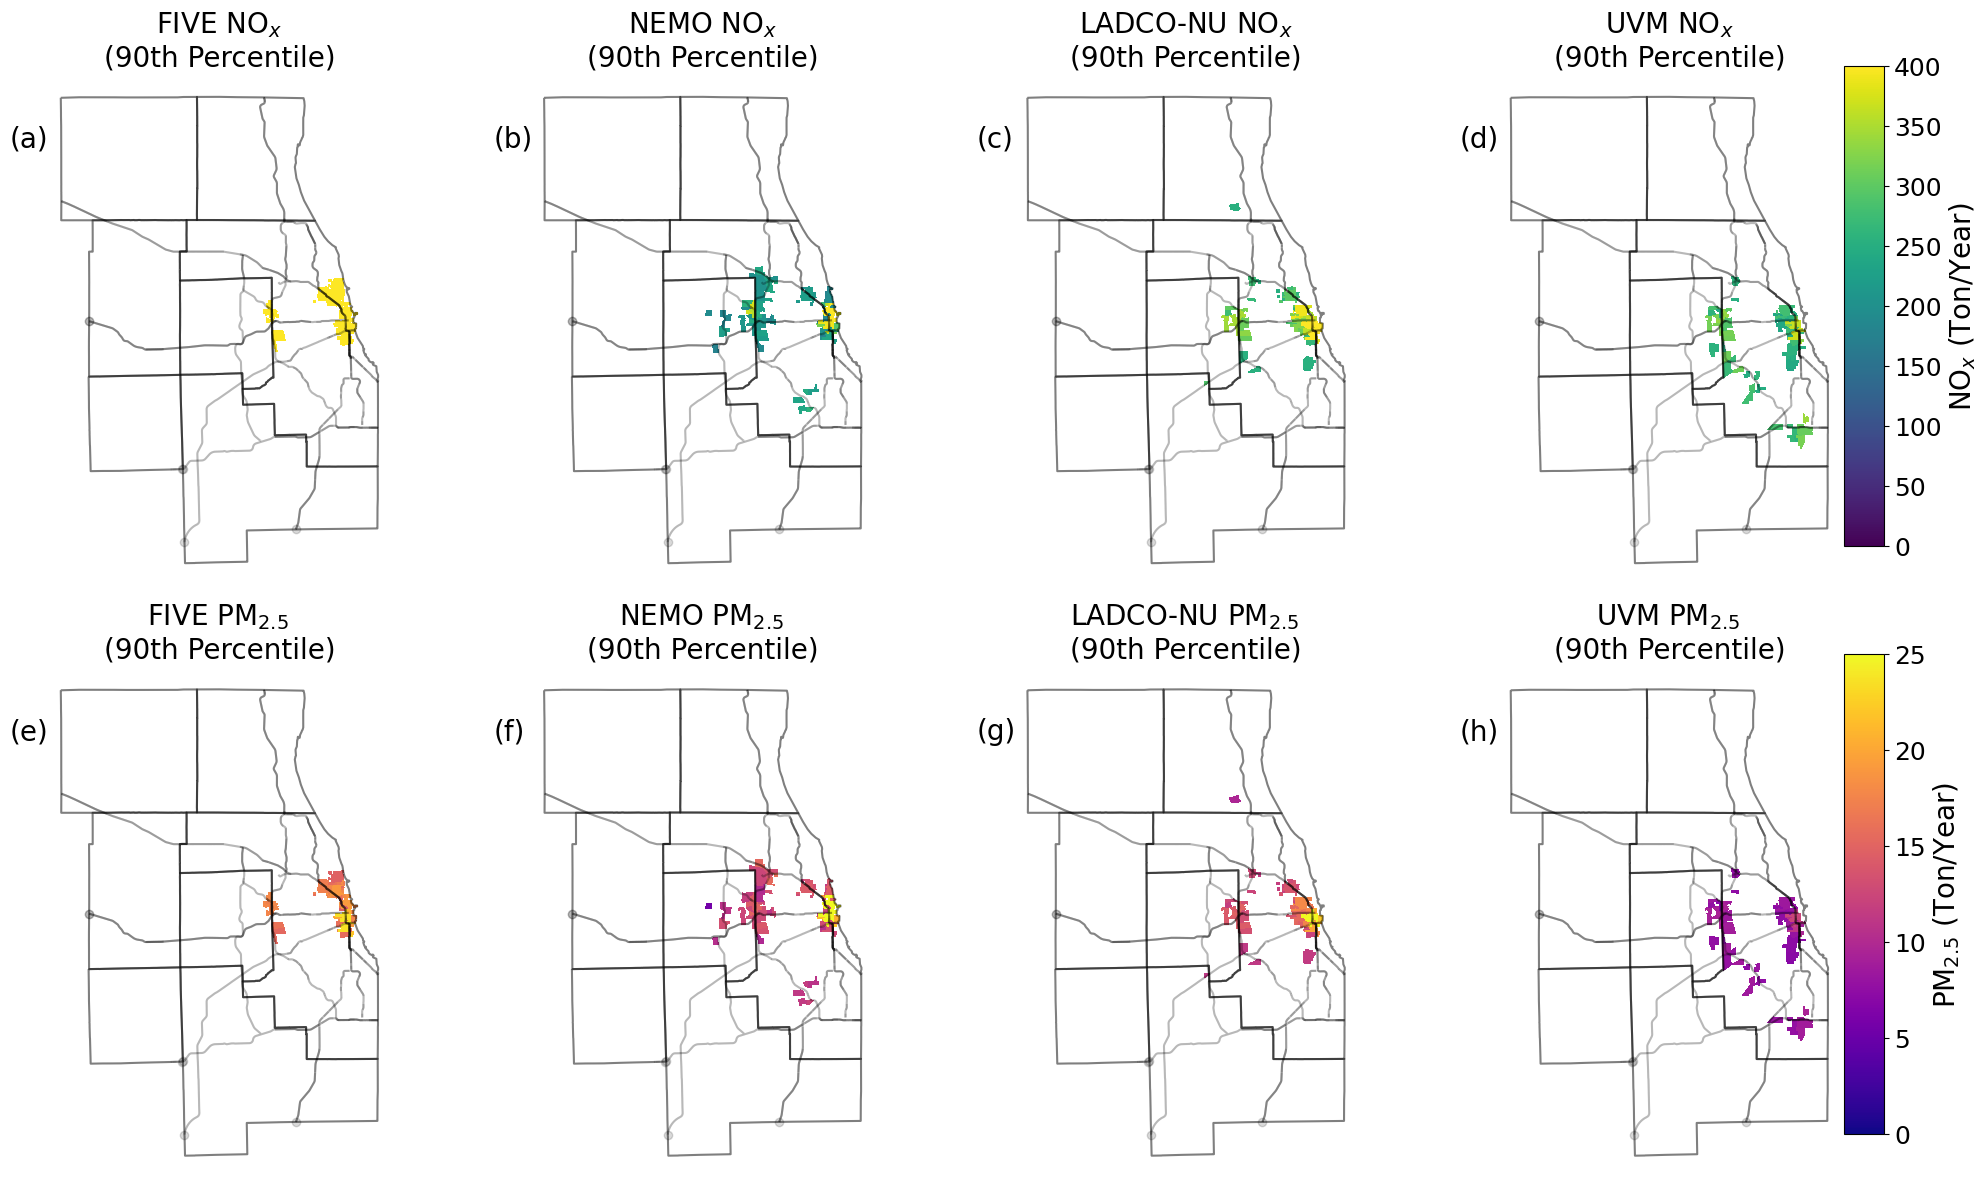

In [19]:
from matplotlib.colors import Normalize
#################################
####### Absolute Emissions
##################################
# Define Normalize objects for color scaling
nox_norm = Normalize(vmin=0, vmax=400)
pm25_norm = Normalize(vmin=0, vmax=25)

fig, axs = plt.subplots(2, 4, figsize=(20, 12))  # Increase figsize for larger subplots

# Plotting NOx figures with county boundaries and roads for dataframes where NOx is in the 10th decile
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    cmap, label = cmap_data
    cmap_filtered = cmap[cmap['NOX_decile'] == 10].dropna(subset=['NOX'])  # Filter dataframe based on NOX_decile and drop NaNs
    row = 0  # First row for NOx
    col = i  # Each column represents a different dataset
    cmap_filtered.plot('NOX', ax=axs[row, col], norm=nox_norm, cmap='viridis', legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row, col], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row, col], color='k', alpha=0.15)  # Add roads
    axs[row, col].set_title(f'{label} NO$_x$ \n(90th Percentile)', fontsize=20)
    axs[row, col].text(-0.1, 0.9, f'({chr(97 + i)})', transform=axs[row, col].transAxes, fontsize=20, va='top')  # Add subplot label (a, b, c, ...)

# Plotting PM2.5 figures with county boundaries and roads for dataframes where NOx is in the 10th decile
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    cmap, label = cmap_data
    cmap_filtered = cmap[cmap['NOX_decile'] == 10].dropna(subset=['PM25'])  # Filter dataframe based on NOX_decile and drop NaNs
    row = 1  # Second row for PM2.5
    col = i  # Each column represents a different dataset
    cmap_filtered.plot('PM25', ax=axs[row, col], norm=pm25_norm, cmap='plasma', legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row, col], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row, col], color='k', alpha=0.15)  # Add roads
    axs[row, col].set_title(f'{label} PM$_{{2.5}}$ \n(90th Percentile)', fontsize=20)
    axs[row, col].text(-0.1, 0.9, f'({chr(101 + i)})', transform=axs[row, col].transAxes, fontsize=20, va='top')  # Add subplot label (e, f, g, ...)

# Turn off axis for all subplots
for ax in axs.flatten():
    ax.set_axis_off()

# Adding colorbars to the right of the figures
cbar_ax1 = fig.add_axes([0.95, 0.54, 0.02, 0.4])  # [left, bottom, width, height]
cbar1 = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax1, orientation='vertical')
cbar1.set_label('NO$_x$ (Ton/Year)', fontsize=20)
cbar1.ax.tick_params(labelsize=18)  # Increase tick font size

cbar_ax2 = fig.add_axes([0.95, 0.05, 0.02, 0.4])  # [left, bottom, width, height]
cbar2 = plt.colorbar(axs[1, 1].collections[0], cax=cbar_ax2, orientation='vertical')
cbar2.set_label('PM$_{2.5}$ (Ton/Year)', fontsize=20)
cbar2.ax.tick_params(labelsize=18)  # Increase tick font size

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Decrease wspace and hspace for less whitespace

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
#plt.savefig('NOX_4km_CensusTracts_90thPercentile.png')
plt.show()


C:\Users\x12la\AppData\Local\Temp\ipykernel_9060\422204764.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding


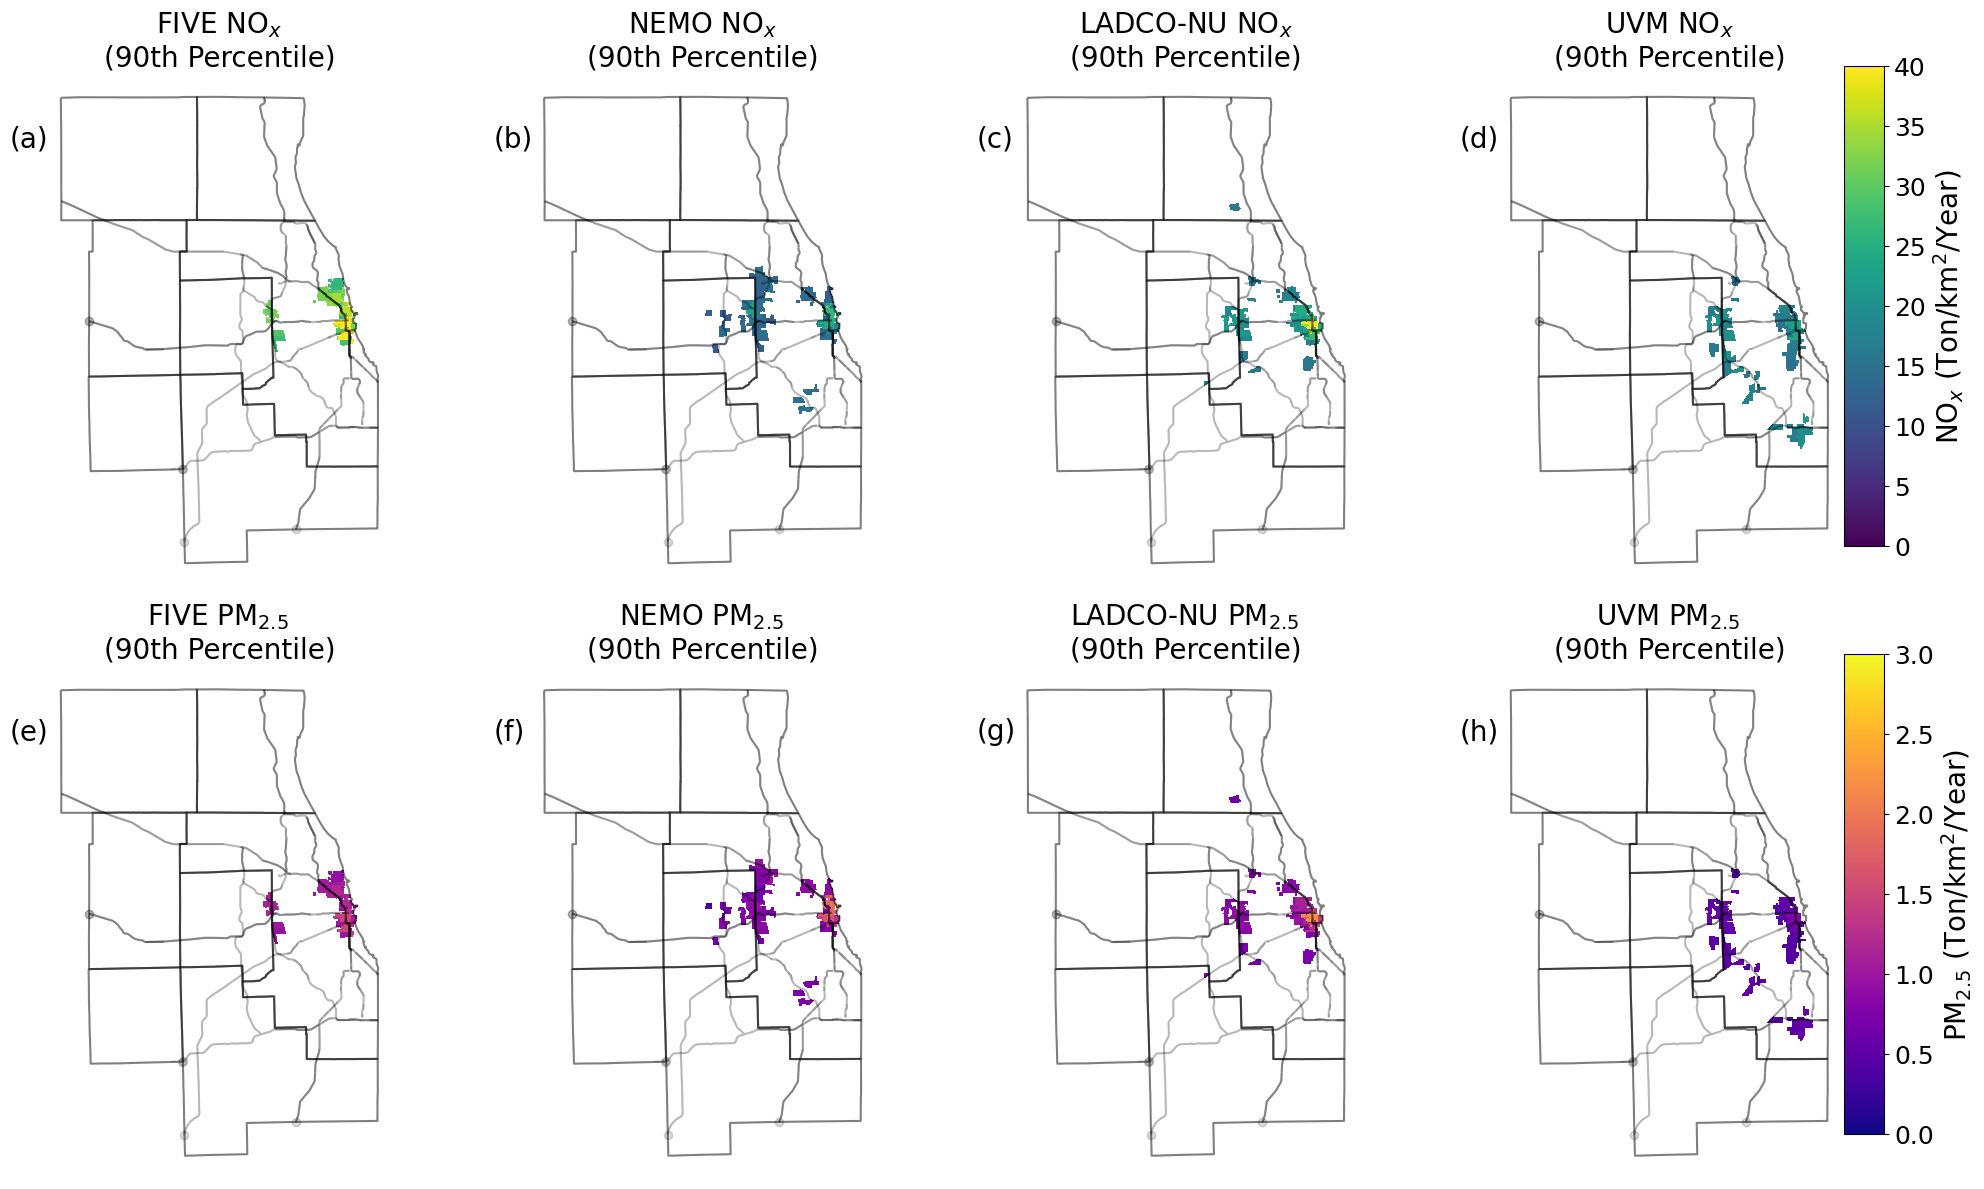

In [20]:
#################################
####### Emission Flux
##################################

# Define Normalize objects for color scaling
nox_norm = Normalize(vmin=0, vmax=40)
pm25_norm = Normalize(vmin=0, vmax=3)

fig, axs = plt.subplots(2, 4, figsize=(20, 12))  # Increase figsize for larger subplots

# Plotting NOx figures with county boundaries and roads for dataframes where NOx is in the 10th decile
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    cmap, label = cmap_data
    cmap_filtered = cmap[cmap['NOX_flux_decile'] == 10].dropna(subset=['NOX_flux'])  # Filter dataframe based on NOX_decile and drop NaNs
    row = 0  # First row for NOx
    col = i  # Each column represents a different dataset
    cmap_filtered.plot('NOX_flux', ax=axs[row, col], norm=nox_norm, cmap='viridis', legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row, col], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row, col], color='k', alpha=0.15)  # Add roads
    axs[row, col].set_title(f'{label} NO$_x$ \n(90th Percentile)', fontsize=20)
    axs[row, col].text(-0.1, 0.9, f'({chr(97 + i)})', transform=axs[row, col].transAxes, fontsize=20, va='top')  # Add subplot label (a, b, c, ...)

# Plotting PM2.5 figures with county boundaries and roads for dataframes where NOx is in the 10th decile
for i, cmap_data in enumerate([(cmap_five, 'FIVE'), (cmap_nemo, 'NEMO'), (cmap_ladco, 'LADCO-NU'), (cmap_rowan, 'UVM')]):
    cmap, label = cmap_data
    cmap_filtered = cmap[cmap['NOX_flux_decile'] == 10].dropna(subset=['PM25_flux'])  # Filter dataframe based on NOX_decile and drop NaNs
    row = 1  # Second row for PM2.5
    col = i  # Each column represents a different dataset
    cmap_filtered.plot('PM25_flux', ax=axs[row, col], norm=pm25_norm, cmap='plasma', legend=False, antialiased=False)
    cmap_cty.boundary.plot(ax=axs[row, col], color='k', alpha=0.5)  # Add county boundaries
    cmap_roads.plot(ax=axs[row, col], color='k', alpha=0.15)  # Add roads
    axs[row, col].set_title(f'{label} PM$_{{2.5}}$ \n(90th Percentile)', fontsize=20)
    axs[row, col].text(-0.1, 0.9, f'({chr(101 + i)})', transform=axs[row, col].transAxes, fontsize=20, va='top')  # Add subplot label (e, f, g, ...)

# Turn off axis for all subplots
for ax in axs.flatten():
    ax.set_axis_off()

# Adding colorbars to the right of the figures
cbar_ax1 = fig.add_axes([0.95, 0.54, 0.02, 0.4])  # [left, bottom, width, height]
cbar1 = plt.colorbar(axs[0, 0].collections[0], cax=cbar_ax1, orientation='vertical')
cbar1.set_label('NO$_x$ (Ton/km$^2$/Year)', fontsize=20)
cbar1.ax.tick_params(labelsize=18)  # Increase tick font size

cbar_ax2 = fig.add_axes([0.95, 0.05, 0.02, 0.4])  # [left, bottom, width, height]
cbar2 = plt.colorbar(axs[1, 1].collections[0], cax=cbar_ax2, orientation='vertical')
cbar2.set_label('PM$_{2.5}$ (Ton/km$^2$/Year)', fontsize=20)
cbar2.ax.tick_params(labelsize=18)  # Increase tick font size

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Decrease wspace and hspace for less whitespace

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.savefig('NOX_4km_CensusTracts_90thPercentile.png')
plt.show()
